In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

pd.set_option('display.max_rows', None)

today = datetime.now()
start_date_10y = today - timedelta(days=365*10)
start_date_2y = today - timedelta(days=365*2)

stocks_df = pd.read_csv('sp_500_stocks.csv')

stocks = stocks_df['Ticker'].tolist()

data_5yr = yf.download(stocks, period="5y")#comment if you want to test on historical data
data_2yr = yf.download(stocks, period="2y")#comment if you want to test on historical data
data_6mo = yf.download(stocks, period="6mo")#comment if you want to test on historical data

#data_10yr = yf.download(stocks, start=start_date_10y, end=today) #uncomment if you want to test on historical data

[*********************100%***********************]  505 of 505 completed
ERROR:yfinance:
45 Failed downloads:
ERROR:yfinance:['NLOK', 'CTXS', 'WLTW', 'FBHS', 'PBCT', 'VAR', 'PKI', 'BLL', 'MXIM', 'DISH', 'ETFC', 'DISCK', 'DRE', 'CXO', 'MYL', 'PXD', 'ABC', 'FRC', 'TWTR', 'ANTM', 'CTL', 'XLNX', 'KSU', 'INFO', 'FLT', 'PEAK', 'FLIR', 'RE', 'ATVI', 'BRK.B', 'COG', 'ALXN', 'NBL', 'VIAC', 'HFC', 'ABMD', 'TIF', 'DISCA', 'FB', 'CERN', 'NLSN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')
ERROR:yfinance:['SIVB']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d']")
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=5y)')
ERROR:yfinance:['FISV']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']")
ERROR:yfinance:['LB']: YFInvalidPeriod

this very simple strategy is tested only on sp500 AND cac40

## **STOCK PICKING : **

In [ ]:

lowest_stocks = {}
stock_counter=0
for stock in stocks:
    stock_counter+=1
    if stock_counter%100==0:
        print(stock_counter)
    if stock not in data_6mo['Close'] or stock not in data_2yr['Close']:
      continue
    stock_data_6mo = data_6mo['Close'][stock]
    stock_data_2yr = data_2yr['Close'][stock]

    lowest_price_6m = stock_data_6mo.min()
    max_price_6m = stock_data_6mo.max()
    max_price_2yr = stock_data_2yr.max()
    if max_price_2yr <=0.1:
        continue
    # Get the current price (most recent closing price)
    current_price = stock_data_6mo[-1]

    # Check if the current price is at or near the lowest point
    if current_price <= 0.1*(max_price_6m-lowest_price_6m) + lowest_price_6m  and max_price_2yr>=2*lowest_price_6m:
        lowest_stocks[stock] = {
            'Lowest Price (6mo)': lowest_price_6m,
            'Current Price': current_price,
            'Shares to buy': 100/current_price
        }

print("BUY THESE STOCKS and sell when they reach +75%, otherwise wait and sell them after 2 years :")

results_df = pd.DataFrame(lowest_stocks).T
sorted_results_df = results_df.sort_values(by='Current Price', ascending=False)
print(sorted_results_df)

<ipython-input-40-7a795e96263c>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = stock_data_6mo[-1]


100
200
300
400
500
BUY THESE STOCKS and sell when they reach 75%, otherwise wait and sell them after 2 years :
      Lowest Price (6mo)  Current Price  Shares to buy
EL             86.199997      92.190002       1.084716
AAP            48.965000      48.965000       2.042275
INTC           18.990000      20.115000       4.971414
WBA            10.025000      10.025000       9.975063


## Test the method on historical data


In [ ]:
lowest_stocks = {}
counter=0
lowest_stocks_list=[]
last_prices =[]

start_date_10y = start_date_10y.replace(tzinfo=None)
start_date_2y = start_date_2y.replace(tzinfo=None)

for stock in stocks:
    counter+=1
    if counter%100==0:
        print(counter)
    if stock not in data_10yr['Close']:
      continue
    # index is timezone-naive
    stock_data_10y = data_10yr['Close'][stock].tz_localize(None)

    # Define the period T-10Y to T-2Y
    stock_data_period = stock_data_10y[start_date_10y:start_date_2y]

    # Get 6-month and 5-year price windows
    for date in stock_data_period.index:
        end_6mo = date
        start_6mo = date - pd.DateOffset(months=6)
        start_2yr = max(date - pd.DateOffset(years=2), stock_data_10y.index[0])
        if date.year == 2020: #skip corona year
            continue
        if start_6mo < stock_data_10y.index[0]:
            continue
        if start_2yr < stock_data_10y.index[0]:
            continue


        stock_data_6mo = stock_data_10y[start_6mo:end_6mo]
        stock_data_5yr = stock_data_10y[start_2yr:end_6mo]

        lowest_price_6m = stock_data_6mo.min()
        max_price_6m = stock_data_6mo.max()
        max_price_2yr = stock_data_5yr.max()
        if max_price_2yr <=0.1:
            continue

        current_price = stock_data_10y[date]

        # Check the condition
        if current_price <= 0.1*(max_price_6m - lowest_price_6m) + lowest_price_6m and max_price_2yr >= 2*lowest_price_6m:
            if date + pd.DateOffset(years=2) <= stock_data_10y.index[-1]:
                max_price_from_date_to_today = stock_data_10y[date:date + pd.DateOffset(years=2)].max()
                date_after_2Y = date + pd.DateOffset(years=2)
                last_price_after_2Y = stock_data_10y[date:date_after_2Y][-1]
            else:
                max_price_from_date_to_today = stock_data_10y[date:].max()
                date_after_2Y = stock_data_10y.index[-1]
                last_price_after_2Y  = stock_data_10y[-1]

            if abs(max_price_from_date_to_today - current_price)>=0.00001:
                # lowest_stocks[stock] = {
                #     'Date of Condition': date,
                #     'Lowest Price (6mo)': lowest_price_6m,
                #     'Current Price at Date': current_price,
                #     'Max Price from Date to Today': max_price_from_date_to_today,
                #     'percentage increase': (max_price_from_date_to_today - current_price) / current_price * 100
                # }
                #print(f"  at this date, current price = {current_price} and max price for the previous 5 year is {max_price_2yr}")
                lowest_stocks_list.append({
                    'Stock': stock,
                    'Date of Condition': date,
                    'Lowest Price (6mo)': lowest_price_6m,
                    'Current Price at Date': current_price,
                    'Max Price from Date to Today': max_price_from_date_to_today,
                    'percentage increase': (max_price_from_date_to_today - current_price) / current_price * 100
                })

                last_prices.append({
                    'Stock': stock,
                    'Date of Condition': date,
                    'date_after_2Y':date_after_2Y,
                    'Last Price after 2Y': last_price_after_2Y,
                    'percentage diff': (last_price_after_2Y-current_price)/current_price*100
                })

results_df = pd.DataFrame(lowest_stocks_list)


<ipython-input-25-f100a635375f>:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price_after_2Y = stock_data_10y[date:date_after_2Y][-1]


100
200
300
400
500


## PERCENTAGE DIFF IF WE DONT PUT A SELL LIMIT

In [ ]:
last_prices_df = pd.DataFrame(last_prices)
last_prices_df.set_index('Stock', inplace=True)
#print(last_prices_df)
last_prices_df['percentage diff'] = pd.to_numeric(last_prices_df['percentage diff'], errors='coerce')
percentage_diff = last_prices_df['percentage diff']


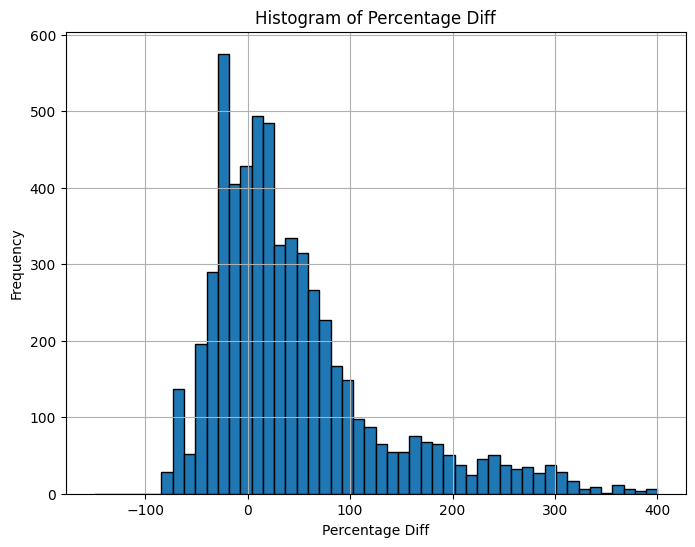

In [ ]:
import matplotlib.pyplot as plt
# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(percentage_diff, bins=50, edgecolor='black', range=(-150, 400))
plt.title('Histogram of Percentage Diff')
plt.xlabel('Percentage Diff')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
def calculate_percentage_diff(percentage_diff, limit_order_percent):
    filtered_diff = percentage_diff[percentage_diff < limit_order_percent]
    mean_value = filtered_diff.mean()
    median_value = filtered_diff.median()
    return mean_value, median_value

thresholds = list(range(5, 155, 2))

# Store results
results = []

for threshold in thresholds:
    filtered_diff = percentage_diff[percentage_diff < threshold]
    mean_value = filtered_diff.mean()
    median_value = filtered_diff.median()
    results.append((threshold, mean_value, median_value))

percentage_diff_mean_df = pd.DataFrame(results, columns=['limit order in %', 'Mean Percentage Diff after Maturity', 'Median Percentage Diff'])
#print(percentage_diff_mean_df)

    limit order in %  Mean Percentage Diff after Maturity  \
0                  5                           -23.924569   
1                  7                           -22.605560   
2                  9                           -21.431670   
3                 11                           -20.249197   
4                 13                           -19.163046   
5                 15                           -18.184532   
6                 17                           -16.969932   
7                 19                           -15.839961   
8                 21                           -14.564813   
9                 23                           -13.547630   
10                25                           -12.542722   
11                27                           -11.765318   
12                29                           -10.809562   
13                31                           -10.209380   
14                33                            -9.418784   
15                35    

In [ ]:
mean_value_of_percent_after2Y = percentage_diff.mean()
median_value_of_percent_after2Y = percentage_diff.median()
print("if you buy a stock satisfying the condition and you dont put a sell limit, then after 2 years the average percentage diff is : ",mean_value_of_percent_after2Y)
print("median_value_of_percent_after2Y: ",median_value_of_percent_after2Y)

if you buy a stock satisfying the condition and you dont put a sell limit, then after 2 years the average percentage diff is :  53.310518237684136
median_value_of_percent_after2Y:  23.365651444239273


In [ ]:

#results_df = pd.DataFrame(lowest_stocks).T #if you are not using lowest_stocks_list
results_df.set_index('Stock', inplace=True) #if you are using lowest_stocks_list
#print(results_df)
results_df['percentage increase'] = pd.to_numeric(results_df['percentage increase'], errors='coerce')
print("analytics on percentage increase : ")
percentage_increase = results_df['percentage increase']


mean_value = percentage_increase.mean()
max_value = percentage_increase.max()
min_value = percentage_increase.min()

median_value = percentage_increase.median()
percentile_90 = percentage_increase.quantile(0.9)
percentile_80 = percentage_increase.quantile(0.8)
percentile_70 = percentage_increase.quantile(0.7)
percentile_60 = percentage_increase.quantile(0.6)
percentile_40 = percentage_increase.quantile(0.4)
percentile_30 = percentage_increase.quantile(0.3)
percentile_20 = percentage_increase.quantile(0.2)
percentile_10 = percentage_increase.quantile(0.1)


five_minimal_values = percentage_increase.nsmallest(5)


print(f"Mean: {mean_value}")
print(f"Max: {max_value}")
print(f"Min: {min_value}")
print(f"Median: {median_value}")
print(f"90th Percentile: {percentile_90}")
print(f"80th Percentile: {percentile_80} -> 20% of chance to reach {percentile_80}% gain")
print(f"70th Percentile: {percentile_70}")
print(f"60th Percentile: {percentile_60}")
print(f"50th Percentile: {median_value}")
print(f"40th Percentile: {percentile_40}")
print(f"30th Percentile: {percentile_30}")
print(f"20th Percentile: {percentile_20} -> 80% of chance to reach {percentile_20}% gain and if this is your sell limit and it is never reached you will earn :{calculate_percentage_diff(percentage_diff, percentile_20)[0]}%")
print(f"10th Percentile: {percentile_10} -> 90% of chance to reach {percentile_10}% gain")
print(f"10 Minimal Values: \n{five_minimal_values}")

analytics on percentage increase : 
Mean: 88.88851086535301
Max: 838.2715904027691
Min: 0.011381584596123472
Median: 55.63434065391812
90th Percentile: 204.28433194566352
80th Percentile: 122.54659102520044 -> 20% of chance to reach 122.54659102520044% gain
70th Percentile: 95.82363962446802
60th Percentile: 71.13058582790062
50th Percentile: 55.63434065391812
40th Percentile: 44.075395929206024
30th Percentile: 32.92794679613035
20th Percentile: 23.55815624123759 -> 80% of chance to reach 23.55815624123759% gain and if this is your sell limit and it is never reached you will earn :-13.24106478733414%
10th Percentile: 13.753696283285208 -> 90% of chance to reach 13.753696283285208% gain
10 Minimal Values: 
Stock
RNO.PA    0.011382
RNO.PA    0.063269
COTY      0.071686
GE        0.130975
BKR       0.166998
Name: percentage increase, dtype: float64


expected return :


In [ ]:
df = pd.DataFrame({
    'sell_limit in %': [percentile_10, percentile_20, percentile_30, percentile_40,median_value, percentile_60, percentile_70, percentile_80, percentile_90],
    'probability': [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
})
df['if_limit_not_reached avg return:'] = df['sell_limit in %'].apply(lambda x: calculate_percentage_diff(percentage_diff, x)[0])
df['expected_return in %'] = df.apply(lambda row: (row['sell_limit in %'] * row['probability']) + ((1 - row['probability']) * row['if_limit_not_reached avg return:']), axis=1)

print(df)

   sell_limit in %  probability  if_limit_not_reached  expected_return in %
0        13.753696          0.9            -18.794376             10.498889
1        23.558156          0.8            -13.241065             16.198312
2        32.927947          0.7             -9.457223             20.212396
3        44.075396          0.6             -5.143582             24.387805
4        55.634341          0.5             -0.414128             27.610106
5        71.130586          0.4              5.145443             31.539500
6        95.823640          0.3             12.164292             37.262096
7       122.546591          0.2             16.890856             38.022003
8       204.284332          0.1             29.176864             46.687610


In [ ]:
"""
stocks = ["AAPL"]
today = datetime.now()
ten_years_ago = today - timedelta(days=3650)  # Approximately 10 years
two_years_ago = today - timedelta(days=730)

for stock in stocks:
        # Download data for the past 10 years
        stock_data_10y = data_10yr['Close'][stock]

        # Iterate through each day in the [T-10Y, T-2Y] period
        for date in pd.date_range(start=ten_years_ago, end=two_years_ago):
            print("date : ",date)
            if date not in stock_data_10y.index:
                print("  ->skip because date is not in index")
                continue

            # Calculate metrics for the 6-month period ending on this date
            six_months_prior = date - timedelta(days=180)
            data_6mo = stock_data_10y.loc[six_months_prior:date]

            if len(data_6mo) < 20:  # Ensure we have enough data points
                print("  ->skip")
                continue

"""

Streaming output truncated to the last 5000 lines.
date :  2015-10-22 12:32:32.710676
  ->skip because date is not in index
date :  2015-10-23 12:32:32.710676
  ->skip because date is not in index
date :  2015-10-24 12:32:32.710676
  ->skip because date is not in index
date :  2015-10-25 12:32:32.710676
  ->skip because date is not in index
date :  2015-10-26 12:32:32.710676
  ->skip because date is not in index
date :  2015-10-27 12:32:32.710676
  ->skip because date is not in index
date :  2015-10-28 12:32:32.710676
  ->skip because date is not in index
date :  2015-10-29 12:32:32.710676
  ->skip because date is not in index
date :  2015-10-30 12:32:32.710676
  ->skip because date is not in index
date :  2015-10-31 12:32:32.710676
  ->skip because date is not in index
date :  2015-11-01 12:32:32.710676
  ->skip because date is not in index
date :  2015-11-02 12:32:32.710676
  ->skip because date is not in index
date :  2015-11-03 12:32:32.710676
  ->skip because date is not in index
